In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.special
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

import keras
import keras.preprocessing.image
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if '..' not in sys.path:
    sys.path.append('..')
import src
import src.vector_vortex_beams as VVB
import src.utils as utils
from src.utils import abs2

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Generate simulated images

Simple example of generating a VVB image with m1=-5 and m2=1

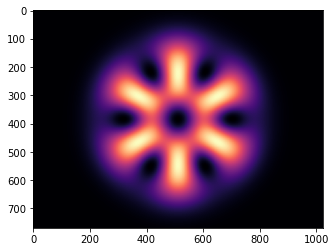

In [2]:
# Camera resolution
camera_width = 1024
camera_height = 768
# X and Y contain the coordinates of the pixels onto which the LG modes will be evaluated
Y, X = np.meshgrid(
    np.linspace(-camera_height / 2, camera_height / 2, num=camera_height + 1),
    np.linspace(-camera_width / 2, camera_width / 2, num=camera_width + 1),
    indexing='ij'
)
w0=150

amps = VVB.LaguerreGauss(x=X, y=Y, p=0, m=-5, w0=w0) + VVB.LaguerreGauss(x=X, y=Y, p=0, m=1, w0=w0)
intensities = np.abs(amps)**2
plt.imshow(intensities, interpolation='nearest', cmap='magma');

The following code is used to generate a dataset of images of the type used to train and classify CNNs.
The dataset consists of a single directory containing a number of subdirectory. Each subdirectory corresponds to a pair of OAM quantum numbers $(m_1, m_2)$, and contains Stokes parameters of VVBs of the form $|H,m_1\rangle+e^{i\phi}|V,m_2\rangle$ for various values of the phase $\phi$.

In [90]:
target_dir = '../data/simulated15classes'
if os.path.isdir(target_dir):
    raise ValueError('The dataset directory already exists!')

classes = [(-1, 1), (-3, 3), (-5, 5),
           (-5, -3), (-5, -1), (-5, 1), (-5, 3),
           (-3, -1), (-3, 1), (-3, 5),
           (-1, 3), (-1, 5), (1, 3), (1, 5), (3, 5)]
classes_names = []
for class_ in classes:
    classes_names.append('{:+}{:+}'.format(class_[0], class_[1]))
# create parent dir
os.mkdir(target_dir)
# create a subdir for each class
for class_, class_name in zip(classes, classes_names):
    # build path and create directory in it
    subdir_name = os.path.join(target_dir, class_name)
    os.mkdir(subdir_name)
    # we use 500 phases between 0 and 2pi
    phases = np.linspace(0, 2 * np.pi, 500)
    # for each phase, we generate the correpsonding polarisation vector state, and then the corresponding VVB
    for idx, phase in enumerate(phases):
        pol_state = [1, np.exp(1j * phase)] / np.sqrt(2)
        image_data = VVB.vector_vortex_stokes_pars(X, Y, p=0, m_pair=class_, w0=w0, polarization_state=pol_state)
        image_data[[0, 1, 2]] = image_data[[1, 2, 0]]  # this is to match with the convention used to generate exp data
        image_data = np.transpose(image_data, [1, 2, 0])
        image_data = utils.rescale_array_values(image_data, [0, 255]).astype(np.uint8)
        # save generate image to file (this goes in the appropriate subdirectory)
        output_file_name = os.path.join(subdir_name, '{:03}.png'.format(idx))
        utils.borderless_imshow_save(image_data, outputname=output_file_name, dpi=200)

Same as above but generating noisy images

In [100]:
target_dir = '../data/simulated15classes_noise0.1'
noise_level = 0.1
if os.path.isdir(target_dir):
    raise ValueError('The dataset directory already exists!')

classes = [(-1, 1), (-3, 3), (-5, 5),
           (-5, -3), (-5, -1), (-5, 1), (-5, 3),
           (-3, -1), (-3, 1), (-3, 5),
           (-1, 3), (-1, 5), (1, 3), (1, 5), (3, 5)]
classes_names = []
for class_ in classes:
    classes_names.append('{:+}{:+}'.format(class_[0], class_[1]))
# create parent dir
os.mkdir(target_dir)
# create a subdir for each class
for class_, class_name in progressbar.progressbar(zip(classes, classes_names)):
    subdir_name = os.path.join(target_dir, class_name)
    os.mkdir(subdir_name)
    # make data to fill subdir
    phases = np.linspace(0, 2 * np.pi, 500)
    for idx, phase in enumerate(phases):
        pol_state = [1, np.exp(1j * phase)] / np.sqrt(2)
        image_data = VVB.vector_vortex_stokes_pars(X, Y, p=0, m_pair=class_, w0=w0, polarization_state=pol_state)
        image_data[[0, 1, 2]] = image_data[[1, 2, 0]]  # this is to match with the convention used to generate exp data
        image_data = utils.add_noise_to_array(image_data, noise_level=noise_level)
        image_data = np.transpose(image_data, [1, 2, 0])
        image_data = utils.rescale_array_values(image_data, [0, 255]).astype(np.uint8)
        utils.borderless_imshow_save(image_data, outputname=os.path.join(subdir_name, '{:03}.png'.format(idx)), dpi=200)

| |                                     #            | 14 Elapsed Time: 1:25:33
